In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split 
from torch import optim

In [4]:
from torch import rand


train_path = './digit-recognizer/train.csv'
train_csv = pd.read_csv(train_path, dtype=np.float32)

features_np = train_csv.drop('label', axis=1).to_numpy() / 255
print(features_np.shape)
targets_np = train_csv['label'].to_numpy()
print(targets_np)

features_train, features_test, targets_train, targets_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

features_train = torch.from_numpy(features_train)
targets_train = torch.from_numpy(targets_train).type(torch.LongTensor)

features_test = torch.from_numpy(features_test)
targets_test = torch.from_numpy(targets_test).type(torch.LongTensor)


train_set = TensorDataset(features_train, targets_train)
test_set = TensorDataset(features_test, targets_test)

batch_size = 100 

trainloader = DataLoader(train_set, batch_size=batch_size)
testloader = DataLoader(test_set, batch_size=batch_size)



(42000, 784)
[1. 0. 1. ... 7. 6. 9.]


(784,)


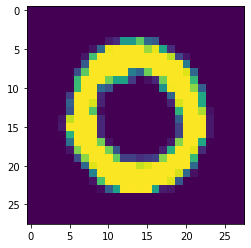

In [6]:

plt.imshow(features_np[1].reshape(28, 28))
print(features_np[1].shape)

In [62]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out
        
model = Network()
model.to(device)

print(model)

Using cuda
Network(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [89]:

epochs = 30
count = 0

for epoch in range(epochs):
    
    train_loss, valid_loss = 0, 0    

    model.train()
    for batch, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        images = images.view(batch_size, 1, 28, 28)
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            model.eval()
            #------ test ------
            total = 0
            correct = 0
            for batch, (images, labels) in enumerate(testloader):
                
                images, labels = images.to(device), labels.to(device)
                images = images.view(batch_size, 1, 28, 28)
                output = model(images)
                
                total += len(labels)
                _, top_class = torch.topk(output, 1, dim=1)
                correct += (top_class == labels.view(*top_class.shape)).sum()
            
            accuracy = correct * 100 / float(total) 
        if(count%500 == 0):
            print(f"Iteration: {count} Accuracy: {accuracy}")

Output: tensor([[ 1.7903e+00, -5.1146e+00, -4.9727e+00, -2.3896e+00,  2.5908e+00,
          1.3733e-01,  1.1774e+01, -2.3593e+00, -1.4494e+00,  2.6581e-01],
        [ 2.2260e+00, -4.4258e+00, -2.5633e+00,  3.6868e+00, -1.5734e+01,
          2.0168e+01,  2.3158e+00, -1.1232e+01,  5.0625e+00,  3.6590e-01],
        [-1.1518e+01, -4.1495e+00,  1.6939e-02,  1.4605e+01, -5.1540e+00,
          3.7657e+00, -1.1297e+01,  2.1611e+00,  4.3691e+00,  1.5915e+00],
        [-9.2152e+00, -5.0465e+00, -4.3881e+00, -9.1227e-01,  1.1451e+01,
         -2.6972e+00, -8.2318e+00,  5.1727e+00,  6.5608e-01,  7.7649e+00],
        [-3.9306e+00,  1.8925e+00,  3.0761e+00,  5.2289e+00, -7.8796e+00,
         -3.2859e+00, -2.1383e+01,  1.8380e+01,  5.5865e-01,  4.9140e+00],
        [ 7.2310e-01, -1.2218e+01,  5.3586e+00,  3.6564e+00, -1.3403e+01,
          4.0614e+00,  7.2761e-01, -5.5664e+00,  1.3820e+01,  5.2817e+00],
        [ 6.9056e+00,  6.4678e-01, -1.0724e+00, -8.3752e+00,  5.6204e+00,
         -5.3092e+00,  1

KeyboardInterrupt: 

In [91]:
finaltest_csv = pd.read_csv('./digit-recognizer/test.csv', dtype=np.float32)

finaltest_np = finaltest_csv.to_numpy() / 255

In [93]:

batch_size = 100
finaltest_tens = torch.from_numpy(finaltest_np)
finaltest_loader = DataLoader(finaltest_tens, batch_size=batch_size)

print(finaltest_tens.shape)

torch.Size([28000, 784])


In [129]:

pred_list = []
for batch, images in enumerate(finaltest_loader):
    
    images = images.to(device)
    images = images.view(batch_size, 1, 28, 28)
    output = model(images)

    _, top_class = torch.topk(output, 1, dim=1)
    
    for e in top_class:
        pred_list.append(e.item())

print(len(pred_list))

28000


In [130]:
outpd = pd.DataFrame({'ImageId': list(range(1, len(pred_list)+1)), 'Label': pred_list})
print(outpd.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


In [131]:
outpd.to_csv('submission.csv', index=False)